In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from utils import *

This notebook contains the applied math library utilities

# Defining Functions

## Kernel

In [1]:
def getKernel(diff_order,acc_order=2,dim=None,scheme='central'):
    '''
        Returns Kernel vector which can be convolved to find the derivative.
        Inputs:
            diff_order: The differential order required
            acc_order: The accuracy order of the kernel (minimum value 2)
            dim: The dimension of the kernel make sure dim > diff_order+acc_order-1
            scheme: Finite differnece scheme (default: central)
            
        Returns:
            A vector of size dim(if not None) else diff_order+acc_order-1
            Note: the extra bits(dim - (diff_order+acc_order-1)) will be padded with 0
    '''
    
    def central(diff_order,acc_order,dim):
        '''
        output index order  .. xi-2 xi-1 xi xi+1 xi+2 ..
        '''
        #minium dim to be 3 it will return an error if the order and the dimension not matches.
        n_eles = diff_order+acc_order-1
        if dim==None:
            dim = n_eles

        if dim<n_eles:
            raise("The dim should be >- than the diff+acc-1")


        kernel = np.zeros(dim)

        B = np.zeros(n_eles)
        B[diff_order] = 1
        A = np.zeros((n_eles,n_eles))
        #first row by 1
        A[0] = np.ones(n_eles)

        numerators = np.zeros(n_eles)
        seq = np.arange(np.floor(n_eles/2))+1
        numerators[:int(np.floor(n_eles/2))] = seq[::-1]
        numerators[int(np.floor((n_eles-1)/2)+1):] = seq
        #let's fill the value of this matrix row wise 
        for i in range(1,n_eles,1):
            fact = np.math.factorial(i) 
            row = []
            prefix = 1
            for j in range(n_eles):
                if j>np.floor((n_eles-1)/2):
                    prefix = (-1)**i

                row.append(prefix*(numerators[j]**i)/fact)
            A[i] = row
        soln = np.linalg.inv(A).dot(B)

        soln = soln[::-1]
        len_sol = len(soln)
        if len_sol%2==0:
            a,b = np.split(soln,2)
            soln = np.zeros(len_sol+1)
            soln[:int(len_sol/2)] = a
            soln[int(len_sol/2)+1:] = b
            len_sol += 1

        kernel = np.pad(soln,int((dim-len_sol)/2))
        return kernel  
    
    
    def right(diff_order,acc_order,dim):
        '''
        output index order  xi xi+1 xi+2 .. ..
        '''
        n_eles = diff_order+acc_order
        B = np.zeros(n_eles)
        B[diff_order] = 1
        A = np.zeros((n_eles,n_eles))

        first_col = np.zeros(n_eles)
        first_col[0] = 1
        A[:,0] = first_col
        A[0] = np.ones(n_eles)

        for i in range(1,n_eles,1):
            for j in range(1,n_eles):
                A[i][j] = (j**i)/np.math.factorial(i) 

        kernel = np.linalg.inv(A).dot(B)
        len_ker = len(kernel)
        
        return kernel
    
    def left(diff_order,acc_order,dim):
        '''
        output index order  xi-2 xi-i xi .. ..
        '''
        n_eles = diff_order+acc_order
        B = np.zeros(n_eles)
        B[diff_order] = 1

        A = np.zeros((n_eles,n_eles))
        A[0] = np.ones(n_eles)        
        first_col = np.zeros(n_eles)
        first_col[0] = 1
        A[:,0] = first_col


        for i in range(1,n_eles,1):
            for j in range(1,n_eles):
                A[i][j] = ((-j)**i)/np.math.factorial(i) 

        kernel = np.linalg.inv(A).dot(B)
        return kernel[::-1]
    
    if scheme=='central':
        return central(diff_order,acc_order,dim)
    elif scheme=='left':
        return left(diff_order,acc_order,dim)
    elif scheme=='right':
        return right(diff_order,acc_order,dim)
        
        

In [250]:
getKernel(diff_order = 1,acc_order=4,scheme='central')

array([ 0.08333333, -0.66666667,  0.        ,  0.66666667, -0.08333333])

In [252]:
getKernel(diff_order = 1,acc_order=4,scheme='left')

array([ 0.25      , -1.33333333,  3.        , -4.        ,  2.08333333])

In [296]:
getKernel(diff_order = 1,acc_order=4,scheme='right')

array([-2.08333333,  4.        , -3.        ,  1.33333333, -0.25      ])

In [396]:
getKernel(diff_order = 3,acc_order=2,scheme='central')

array([-0.5,  1. ,  0. , -1. ,  0.5])

## Padding

In [2]:
## Not to be used
def padInputNaive(X,diff_order,acc_order):
    n_eles = diff_order+acc_order-1
    n_pad = int(np.floor(n_eles/2))
    #pad the before elements
    pre_values = []
    x0 = X[0]
    x1 = X[1]
    x2 = X[2]
    for i in range(n_pad):
        x_prev = x2-3*x1+3*x0
        pre_values.append(x_prev)
        x2 = x1
        x1 = x0
        x0 = x_prev
    pre_values = pre_values[::-1]
    
    post_values = []
    xn = X[-1]
    xn_1 = X[-2]
    xn_2 = X[-3]
    for i in range(n_pad):
        x_post = xn_2 - 3*xn_1+3*xn
        post_values.append(x_post)
        xn_2 = xn_1
        xn_1 = xn
        xn = x_post
    
    X_final = np.concatenate((pre_values,X,post_values))
    #pad the after elements 
    return X_final

In [4]:
def padInput(X,diff_order,acc_order=2,dim=None):
    '''
        pads the required amount in the start and the end by equation the central scheme to right/left scheme
        Inputs:
            X: A vector to be padded        
    '''
    if dim is None:
        dim = diff_order+acc_order-1
    def padStart(X,diff_order,acc_order):
        central_kernel = getKernel(diff_order,acc_order,scheme='central')
        right_kernel = getKernel(diff_order,acc_order,scheme='right')
        n_c = len(central_kernel)
        n_r = len(right_kernel)
        n_eles = diff_order+acc_order-1 #central kernel
        n_pad = int(np.floor(n_eles/2))

        index = int(np.floor(n_c/2))-1
        for i in range(n_pad):
            right_conv = np.correlate(X[index:index+n_r],right_kernel)
            central_conv = np.correlate(X[0:n_c-1],central_kernel[1:])
            x_prev = (right_conv-central_conv)*1.0/central_kernel[0]
            X = np.concatenate((x_prev,X))
        return X

    def padEnd(X,diff_order,acc_order):
        central_kernel = getKernel(diff_order,acc_order,scheme='central')
        left_kernel = getKernel(diff_order,acc_order,scheme='left')
        n_c = len(central_kernel)
        n_l = len(left_kernel)
        n_eles = diff_order+acc_order-1 #central kernel
        n_pad = int(np.floor(n_eles/2))
        index = len(X) - (int(np.floor(n_c/2))-1)
        
        for i in range(n_pad):
            
            left_conv = np.correlate(X[index-n_l:index],left_kernel)
            central_conv = np.correlate(X[-(n_c-1):],central_kernel[:-1])
            x_next = (left_conv-central_conv)*1.0/central_kernel[-1]
            X = np.concatenate((X,x_next))
            index += 1
        return X
    
    X = padStart(X,diff_order,acc_order)
    X = padEnd(X,diff_order,acc_order)
    
    actual_dim = diff_order+acc_order-1
    if actual_dim%2 == 0:
        actual_dim += 1
    
    X = np.pad(X,int((dim-actual_dim)/2))
    return X

In [399]:
X_temp = [1,2,3,4,5,6,7,8,9,10]

In [397]:
np.round(padInput(X_temp,1,2))

array([-0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])

## Testing

Considering f(x) = sin(2x/L)

In [378]:
L = 40
x = np.linspace(1,190,L)
dx = x[1]-x[0]

In [379]:
X = np.sin(2*x/L)
f1X = (2/L)*np.cos(2*x/L)
f2X = -(4/(L**2))*np.sin(2*x/L)

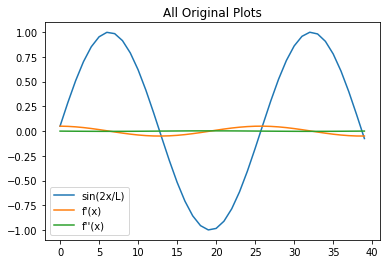

In [380]:
plt.plot(X,label='sin(2x/L)')
plt.plot(f1X,label="f'(x)")
plt.plot(f2X,label="f''(x)")
plt.title("All Original Plots")
plt.legend()
plt.show()

### Approximate f'(x)

Let's vary with accuracy order

In [381]:
acc_order = [2,4,6,8,10]
kernels = []
X_padded = []
f1X_approx = []
for order in acc_order:
    kernels.append(getKernel(1,order))
    X_padded.append(padInput(X,1,order))
    f1X_approx.append(np.correlate(X_padded[-1],kernels[-1])/dx)


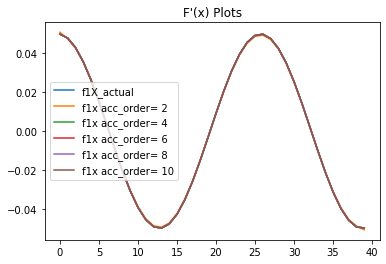

In [382]:
plt.plot(f1X,label="f1X_actual")
for i in range(len(acc_order)):
    plt.plot(f1X_approx[i],label="f1x acc_order= "+str(acc_order[i]))

plt.title("F'(x) Plots")
plt.legend()
plt.show()


Visually it is a bit hard to see the difference, let's plot the mse vs accuracy order (from the actual derivative)

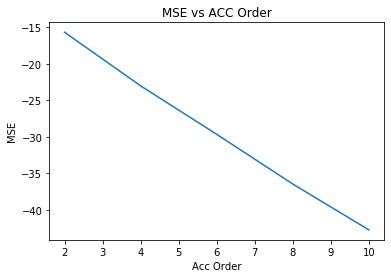

In [383]:
mse = []
for i in range(len(acc_order)):
    mse.append(np.log(np.square(f1X - f1X_approx[i]).mean()))
plt.plot(acc_order,mse)
plt.title("MSE vs ACC Order")
plt.xlabel("Acc Order")
plt.ylabel("MSE")
plt.show()


So we can see that the mse decreases as we increase the Accuracy order i.e we get closer to the actual derivative

### Approximate f''(x)

In [384]:
acc_order = [2,4,6,8,10]
kernels = []
X_padded = []
f2X_approx = []
for order in acc_order:
    kernels.append(getKernel(2,order))
    X_padded.append(padInput(X,2,order))
    f2X_approx.append(np.correlate(X_padded[-1],kernels[-1])/(dx**2))


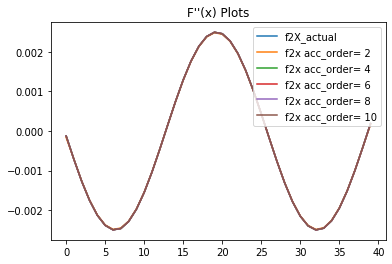

In [385]:
plt.plot(f2X,label="f2X_actual")
for i in range(len(acc_order)):
    plt.plot(f2X_approx[i],label="f2x acc_order= "+str(acc_order[i]))

plt.title("F''(x) Plots")
plt.legend()
plt.show()


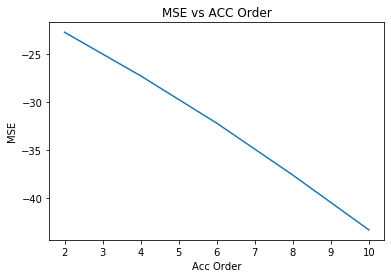

In [386]:
mse = []
for i in range(len(acc_order)):
    mse.append(np.log(np.square(f2X - f2X_approx[i]).mean()))
plt.plot(acc_order,mse)
plt.title("MSE vs ACC Order")
plt.xlabel("Acc Order")
plt.ylabel("MSE")
plt.show()


We can see the same trend for the double derivative

**y = arctan(x)**

In [353]:
L = 40
x = np.linspace(-190,190,L)
dx = x[1]-x[0]

In [361]:
X = np.arctan(2*x/L)
f1X = (2/L)*(1/(1+(2*x/L)**2))
f2X = -4*(f1X**2)*(x/L)

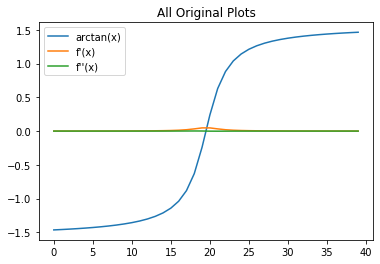

In [362]:
plt.plot(X,label='arctan(x)')
plt.plot(f1X,label="f'(x)")
plt.plot(f2X,label="f''(x)")
plt.title("All Original Plots")
plt.legend()
plt.show()

### Approximate f'(x)

In [363]:
acc_order = [2,4,6,8,10]
kernels = []
X_padded = []
f1X_approx = []
for order in acc_order:
    kernels.append(getKernel(1,order))
    X_padded.append(padInput(X,1,order))
    f1X_approx.append(np.correlate(X_padded[-1],kernels[-1])/dx)


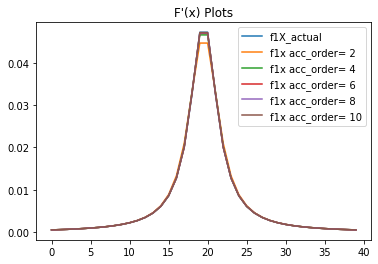

In [364]:
plt.plot(f1X,label="f1X_actual")
for i in range(len(acc_order)):
    plt.plot(f1X_approx[i],label="f1x acc_order= "+str(acc_order[i]))

plt.title("F'(x) Plots")
plt.legend()
plt.show()


we can see the higher accuracy order are closer to the actual derivative

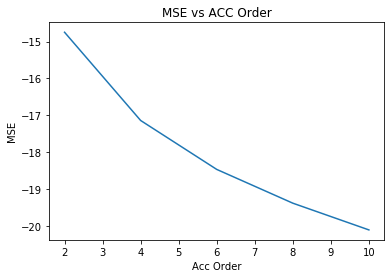

In [365]:
mse = []
for i in range(len(acc_order)):
    mse.append(np.log(np.square(f1X - f1X_approx[i]).mean()))
plt.plot(acc_order,mse)
plt.title("MSE vs ACC Order")
plt.xlabel("Acc Order")
plt.ylabel("MSE")
plt.show()


### Approximate f''(x)

In [366]:
acc_order = [2,4,6,8,10]
kernels = []
X_padded = []
f2X_approx = []
for order in acc_order:
    kernels.append(getKernel(2,order))
    X_padded.append(padInput(X,2,order))
    f2X_approx.append(np.correlate(X_padded[-1],kernels[-1])/(dx**2))


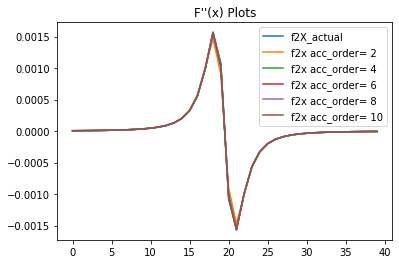

In [367]:
plt.plot(f2X,label="f2X_actual")
for i in range(len(acc_order)):
    plt.plot(f2X_approx[i],label="f2x acc_order= "+str(acc_order[i]))

plt.title("F''(x) Plots")
plt.legend()
plt.show()


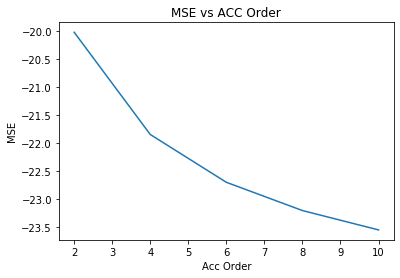

In [368]:
mse = []
for i in range(len(acc_order)):
    mse.append(np.log(np.square(f2X - f2X_approx[i]).mean()))
plt.plot(acc_order,mse)
plt.title("MSE vs ACC Order")
plt.xlabel("Acc Order")
plt.ylabel("MSE")
plt.show()


### Torch/Batch Version

In [7]:
def getKernelTorch(diff_order,acc_order=2,dim=None,scheme='central'):
    
    '''
        returns a kernel of shape (1,1,dim) #so that it be convolved in pdeNet
    '''
    
    def central(diff_order,acc_order,dim):
        '''
        output index order  .. xi-2 xi-1 xi xi+1 xi+2 ..
        '''
        #minium dim to be 3 it will return an error if the order and the dimension not matches.
        n_eles = diff_order+acc_order-1
        if dim==None:
            dim = n_eles

        if dim<n_eles:
            raise("The dim should be >- than the diff+acc-1")


        kernel = np.zeros(dim)

        B = np.zeros(n_eles)
        B[diff_order] = 1
        A = np.zeros((n_eles,n_eles))
        #first row by 1
        A[0] = np.ones(n_eles)

        numerators = np.zeros(n_eles)
        seq = np.arange(np.floor(n_eles/2))+1
        numerators[:int(np.floor(n_eles/2))] = seq[::-1]
        numerators[int(np.floor((n_eles-1)/2)+1):] = seq
        #let's fill the value of this matrix row wise 
        for i in range(1,n_eles,1):
            fact = np.math.factorial(i) 
            row = []
            prefix = 1
            for j in range(n_eles):
                if j>np.floor((n_eles-1)/2):
                    prefix = (-1)**i

                row.append(prefix*(numerators[j]**i)/fact)
            A[i] = row
        soln = np.linalg.inv(A).dot(B)

        soln = soln[::-1]
        len_sol = len(soln)
        if len_sol%2==0:
            a,b = np.split(soln,2)
            soln = np.zeros(len_sol+1)
            soln[:int(len_sol/2)] = a
            soln[int(len_sol/2)+1:] = b
            len_sol += 1

        kernel = np.pad(soln,int((dim-len_sol)/2))
        return kernel  
    
    
    def right(diff_order,acc_order,dim):
        '''
        output index order  xi xi+1 xi+2 .. ..
        '''
        n_eles = diff_order+acc_order
        B = np.zeros(n_eles)
        B[diff_order] = 1
        A = np.zeros((n_eles,n_eles))

        first_col = np.zeros(n_eles)
        first_col[0] = 1
        A[:,0] = first_col
        A[0] = np.ones(n_eles)

        for i in range(1,n_eles,1):
            for j in range(1,n_eles):
                A[i][j] = (j**i)/np.math.factorial(i) 

        kernel = np.linalg.inv(A).dot(B)
        len_ker = len(kernel)
        
        return kernel
    
    def left(diff_order,acc_order,dim):
        '''
        output index order  xi-2 xi-i xi .. ..
        '''
        n_eles = diff_order+acc_order
        B = np.zeros(n_eles)
        B[diff_order] = 1

        A = np.zeros((n_eles,n_eles))
        A[0] = np.ones(n_eles)        
        first_col = np.zeros(n_eles)
        first_col[0] = 1
        A[:,0] = first_col


        for i in range(1,n_eles,1):
            for j in range(1,n_eles):
                A[i][j] = ((-j)**i)/np.math.factorial(i) 

        kernel = np.linalg.inv(A).dot(B)
        return kernel[::-1]
    
    if scheme=='central':
        return torch.from_numpy(np.array(central(diff_order,acc_order,dim))).reshape((1,1,-1)).float()
    elif scheme=='left':
        return torch.from_numpy(np.array(left(diff_order,acc_order,dim))).reshape((1,1,-1)).float()
    elif scheme=='right':
        return torch.from_numpy(np.array(right(diff_order,acc_order,dim))).reshape((1,1,-1)).float()

In [8]:
def padInputTorch(X,diff_order,acc_order=2,dim=None):
    '''
        pads the reqruied amount in the start and the end takes the input (batch_size x n_channels(1) x X_dim
        and returns (batch_size x n_channels(1) x X_dim+padded
    '''
    if dim is None:
        dim = diff_order+acc_order-1
    def padStart(X,diff_order,acc_order):
        central_kernel = getKernelTorch(diff_order,acc_order,scheme='central')
        right_kernel = getKernelTorch(diff_order,acc_order,scheme='right')
        n_c = central_kernel.shape[-1]
        n_r = right_kernel.shape[-1]
        n_eles = diff_order+acc_order-1 #central kernel
        n_pad = int(np.floor(n_eles/2))
        index = int(np.floor(n_c/2))-1
        for i in range(n_pad):
            right_conv = F.conv1d(X[...,index:index+n_r],right_kernel)
            central_conv = F.conv1d(X[...,0:n_c-1],central_kernel[...,1:])
            x_prev = (right_conv-central_conv)*1.0/central_kernel[...,0]
            X = torch.cat((x_prev,X),axis=-1)
        return X

    def padEnd(X,diff_order,acc_order):
        central_kernel = getKernelTorch(diff_order,acc_order,scheme='central')
        left_kernel = getKernelTorch(diff_order,acc_order,scheme='left')
        n_c = central_kernel.shape[-1]
        n_l = left_kernel.shape[-1]
        n_eles = diff_order+acc_order-1 #central kernel
        n_pad = int(np.floor(n_eles/2))
        index = X.shape[-1] - (int(np.floor(n_c/2))-1)
        
        for i in range(n_pad):       
            left_conv = F.conv1d(X[...,index-n_l:index],left_kernel)
            central_conv = F.conv1d(X[...,-(n_c-1):],central_kernel[...,:-1])
            x_next = (left_conv-central_conv)*1.0/central_kernel[...,-1]
            X = torch.cat((X,x_next),axis=-1)
            index += 1
        return X
    X = X.float()
    X = padStart(X,diff_order,acc_order)
    X = padEnd(X,diff_order,acc_order)
    
    actual_dim = diff_order+acc_order-1
    if actual_dim%2 == 0:
        actual_dim += 1
    npad = (int((dim-actual_dim)/2),int((dim-actual_dim)/2))
    X = F.pad(X,npad)

    return X



## Moment

### Numpy versions

In [18]:
def getP(dim):
    ## return the matrix that we have to take dot with moment and kernel
    P = np.zeros((dim,dim))
    for i in range(dim):
        P[i] = ((np.arange(dim)-(dim-1)//2)**i)/np.math.factorial(i)
    invP = np.linalg.inv(P)
    return P,invP

In [76]:

def moment2Kernel(M,invP):
    return np.dot(invP,M)

def kernel2Moment(kernel,P):
    return np.dot(P,kernel)


**Testing for size 3**

In [81]:
k = getKernel(1)
acutal_M = [0,1,0]
P,invP = getP(dim=3)
M_back = kernel2Moment(k,P)
k_back = moment2Kernel(acutal_M,invP)
print(M_back)
print(k_back)


[0. 1. 0.]
[-0.5  0.   0.5]


**Testing with size 5**

In [88]:
k = getKernel(1,dim=5)
P,invP = getP(dim=5)
M_back = kernel2Moment(k,P)
k_back = moment2Kernel(M_back,invP)
print(M_back)
print(k_back)

[0.         1.         0.         0.16666667 0.        ]
[-8.32667268e-17 -5.00000000e-01  7.40148683e-17  5.00000000e-01
  2.77555756e-17]


### Torch Versions

#### Moment related

In [93]:
class _MK(torch.nn.Module):
    def __init__(self, dim):
        '''
        '''
        super(_MK, self).__init__()
        self._dim = dim
        M = np.zeros((dim,dim))
        for i in range(dim):
            M[i] = ((np.arange(dim)-(dim-1)//2)**i)/np.math.factorial(i)
        invM = np.linalg.inv(M)
        self.register_buffer('_M', torch.from_numpy(M))
        self.register_buffer('_invM', torch.from_numpy(invM))

    @property
    def M(self):
        return self._buffers['_M']
    @property
    def invM(self):
        return self._buffers['_invM']

    
    def dim(self):
        return self._dim

    def forward(self):
        pass



In [149]:
class M2K(_MK):
    """
    convert moment matrix to convolution kernel
    Arguments:
        dim (int): kernel dim
    """
    def __init__(self, dim):
        super(M2K, self).__init__(dim)
    def forward(self, m):
        """
        m (Tensor): torch.size=(1,1,dim),
        returns kernel of the same shape
        """
        x = torch.tensordot(self.invM, m, dims=[[1],[-1]])
        x = x.permute([2,1,0])
        return x
    
    
class K2M(_MK):
    """
    convert convolution kernel to moment matrix
    Arguments:
        dim (int): kernel dim
    """
    def __init__(self, shape):
        super(K2M, self).__init__(shape)
    def forward(self, k):
        """
        k (Tensor): torch.size=(1,1,dim),
        returns moment of the same shape
        """
        x = torch.tensordot(self.M, k, dims=[[1],[-1]])
        x = x.permute([2,1,0])
        return x

**Testing**

In [170]:
obj = M2K(3)

In [171]:
k = obj(torch.from_numpy(np.array([1.,0.,0])).reshape(1,1,-1))

In [172]:
print(k)

tensor([[[0., 1., 0.]]], dtype=torch.float64)


In [168]:
obj = K2M(3)

In [169]:
getKernel(1,dim=5,acc_order=5)

array([ 0.08333333, -0.66666667,  0.        ,  0.66666667, -0.08333333])